### import libraries, set parameters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import scanpy.external as sce

import os
import scipy.sparse as ssp
import sys
import pickle

# !!!!
# Change this path to point to folder containing helper_functions.py
sys.path.append('/Users/kalki/Dropbox (HMS)/PhD_lab/SPRING_dev/data_prep/')
import helper_functions_py3 as hf

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figures



/Users/kalki/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Users/kalki/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


### get gene.txt file from counts data

* Use ```gunzip -c 14C.counts.tsv.gz | head -n 1 | tr "\t" "\n" | tail -n +2 > genes.txt``` to get genes.txt file
* move the file to the raw data folder that has counts.tsv.gz



### Load transcriptome data

In [2]:
# path to raw tsv files generated by indrops pipeline:

raw_files = '/Users/kalki/Dropbox (HMS)/PhD_lab/SPRING_dev-master/Raw_data/Indrops5/'
sample_name = []


for file in os.listdir(raw_files):
    if file.endswith('counts.tsv.gz'):
        s = file.split('.')[0]
        sample_name.append(s)

print (sample_name)

['06C_br1_tr1', '08P_br1_tr1', '08C_br1_tr1', '06C_br3_tr1', '08C_br2_tr1', '08P_br3_tr1', '08C_br3_tr1', '06C_br2_tr1', '08P_br2_tr1', '14C_br2_tr1', '14P_br3_tr1', '10P_br2_tr1', '10C_br3_tr1', '14C_br3_tr1', '14P_br2_tr1', '10P_br3_tr1', '10C_br2_tr1', '24P_br2_tr1', '24C_br3_tr1', '14P_br1_tr1', '10C_br1_tr1', '24P_br3_tr1', '24C_br2_tr1', '14C_br1_tr1', '10P_br1_tr1']


In [3]:

adict = {}
sample_name = []


for file in os.listdir(raw_files):
    if file.endswith('counts.tsv.gz'):
        s = file.split('.')[0]
        sample_name.append(s)

        npz_filename = raw_files + '/' + s + '.raw_counts.unfiltered.npz'
        if os.path.isfile(npz_filename):
            print('loading from npz')
            Etmp = ssp.load_npz(npz_filename)
        else:
            print('loading from tsv')
            Etmp = hf.load_text(hf.file_opener(raw_files + '/' + file))#,print_row_interval=1000, start_row=1, start_column=1
            print('saving npz')
            ssp.save_npz(raw_files + '/' + s + '.raw_counts.unfiltered.npz', Etmp, compressed=True)

        adict[s] = sc.AnnData(Etmp)
        adict[s].var_names = pd.read_csv(raw_files + '/genes.txt', header=None, sep='\t')[0]
        adict[s].var_names_make_unique()
        if 'C' in s:
            adict[s].obs['treatment'] = 'control'
        else: 
            adict[s].obs['treatment'] = 'hua'
        if 'br1' in s:
            adict[s].obs['replicate'] = '1'
        if 'br2' in s:
            adict[s].obs['replicate'] = '2'
        if 'br3' in s:
            adict[s].obs['replicate'] = '3'
        if 'tr1' in s:
            adict[s].obs['trep'] = '1'
        if 'tr2' in s:
            adict[s].obs['trep'] = '2'
        
        adict[s].obs['time_point'] = s[:2]

        # set initial guess for minimum total counts - will probably change later on
        adict[s].uns['min_tot'] = 500


        print(s, adict[s].shape)
        del Etmp

loading from npz
06C_br1_tr1 (24317, 30677)
loading from npz
08P_br1_tr1 (5494, 30677)
loading from npz
08C_br1_tr1 (5171, 30677)
loading from npz
06C_br3_tr1 (4255, 30677)
loading from npz
08C_br2_tr1 (13063, 30677)
loading from npz
08P_br3_tr1 (4052, 30677)
loading from npz
08C_br3_tr1 (3301, 30677)
loading from npz
06C_br2_tr1 (6365, 30677)
loading from npz
08P_br2_tr1 (8033, 30677)
loading from npz
14C_br2_tr1 (8145, 30677)
loading from npz
14P_br3_tr1 (7753, 30677)
loading from npz
10P_br2_tr1 (10351, 30677)
loading from npz
10C_br3_tr1 (5054, 30677)
loading from npz
14C_br3_tr1 (5451, 30677)
loading from npz
14P_br2_tr1 (12288, 30677)
loading from npz
10P_br3_tr1 (6963, 30677)
loading from npz
10C_br2_tr1 (9397, 30677)
loading from npz
24P_br2_tr1 (11264, 30677)
loading from npz
24C_br3_tr1 (4317, 30677)
loading from npz
14P_br1_tr1 (13295, 30677)
loading from npz
10C_br1_tr1 (7461, 30677)
loading from npz
24P_br3_tr1 (8952, 30677)
loading from npz
24C_br2_tr1 (19505, 30677)
load

In [4]:

adict_br1 = {}
adict_br2 = {}
adict_br3 = {}

for keys,values in adict.items():
    if 'br1' in keys:
        adict_br1[keys]=values
    if 'br2' in keys:
        adict_br2[keys]=values
    if 'br3' in keys:
        adict_br3[keys]=values

### Filter out background based on UMIs/cell
#### First, plot histograms and tweak thresholds  
No filtering actually done here

##### Replicate 1

['06C_br1_tr1', '08P_br1_tr1', '08C_br1_tr1', '14P_br1_tr1', '10C_br1_tr1', '14C_br1_tr1', '10P_br1_tr1']


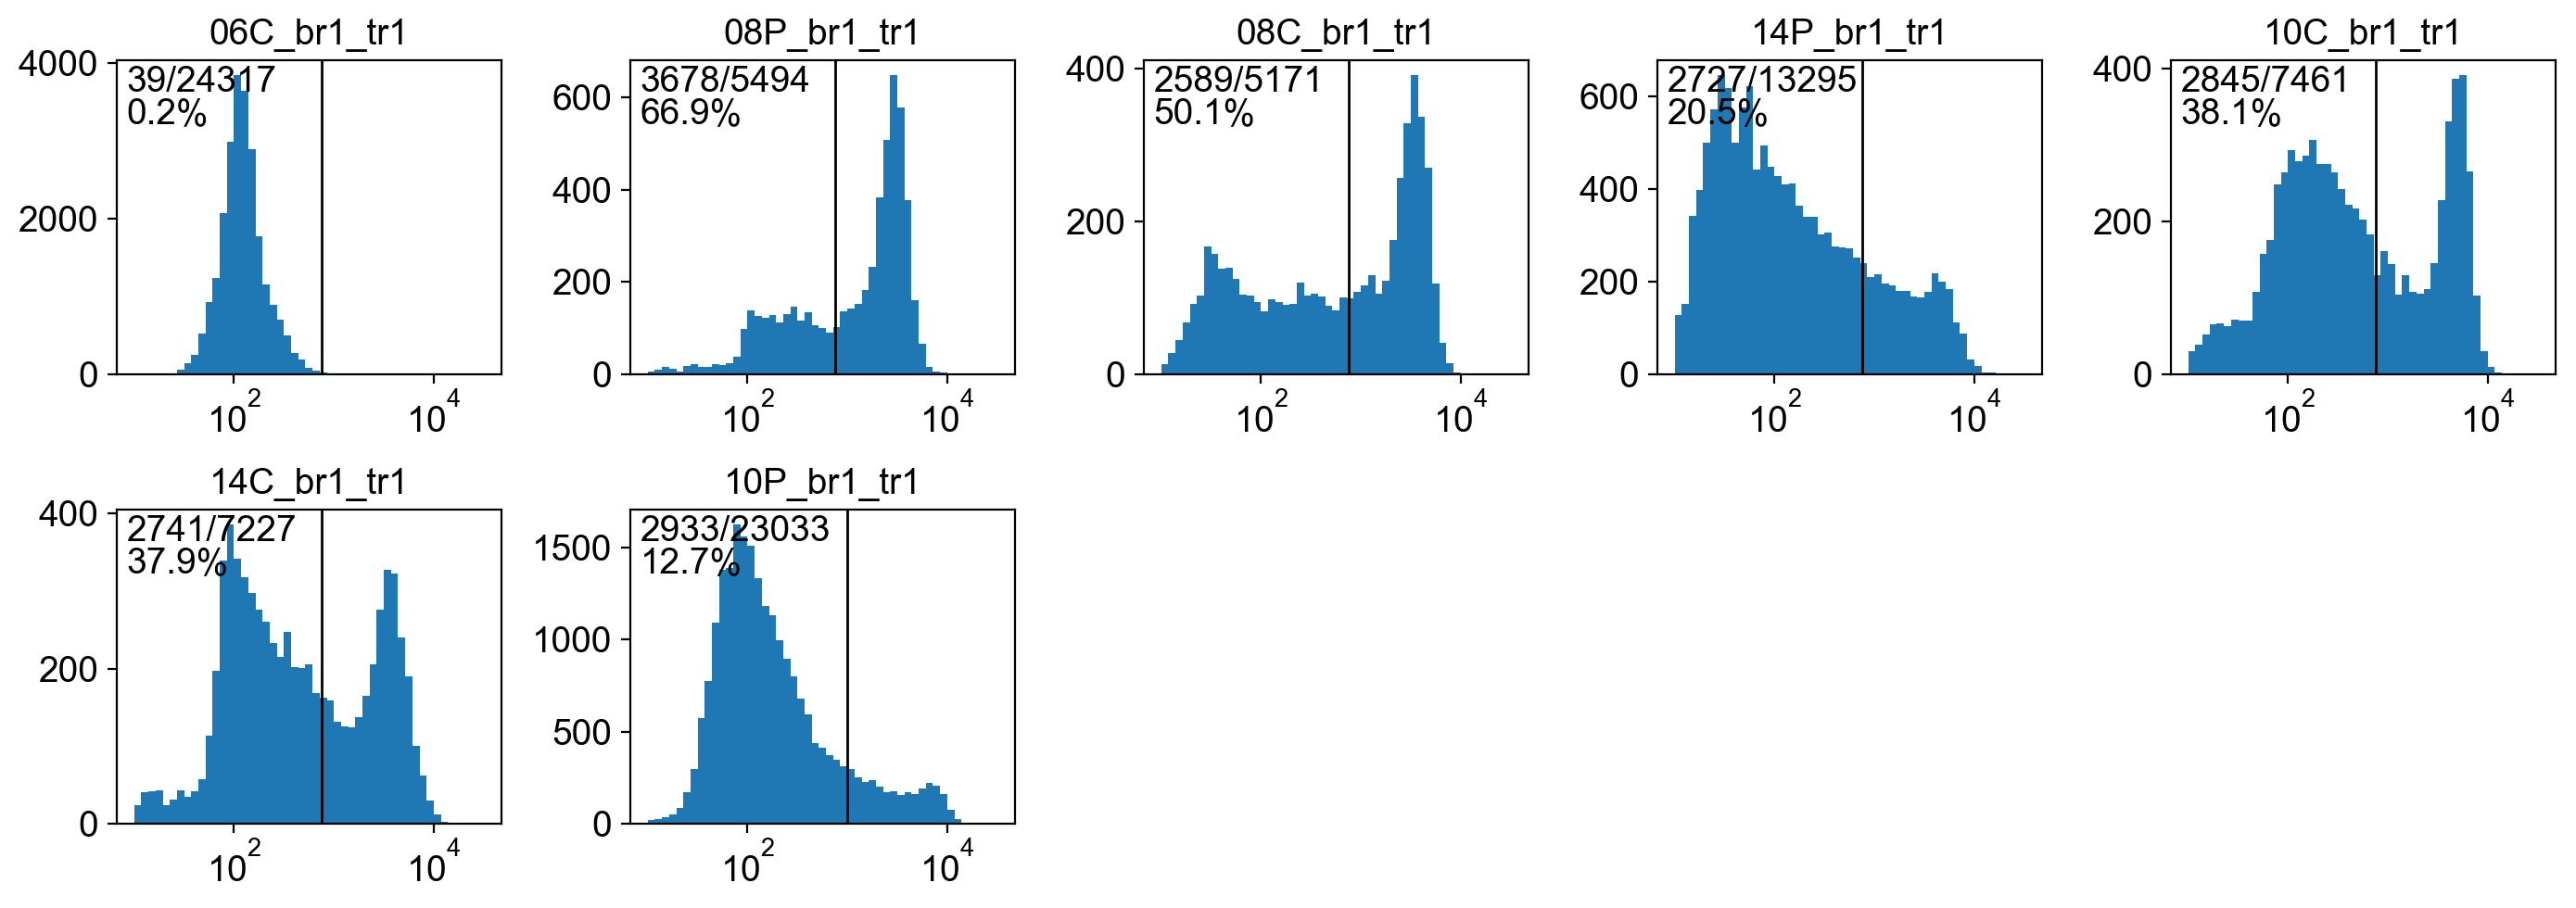

In [5]:
sample_name_br1 = []

for file in os.listdir(raw_files):
    if file.endswith('counts.tsv.gz'):
        s = file.split('.')[0]
        if 'br1' in s:
            sample_name_br1.append(s)

print (sample_name_br1)

for keys in adict_br1:
    adict_br1[keys].uns['min_tot'] = 750
    
adict_br1['10P_br1_tr1'].uns['min_tot'] = 1000

ncol = 5
nrow = int(len(adict_br1) / ncol) + 1

fig = pl.figure(figsize = (14, nrow * 2.5), dpi = 200)
for iS, s in enumerate(sample_name_br1):
    ax = pl.subplot(nrow, ncol, iS + 1)
    
    adict_br1[s].obs['n_counts'] = adict_br1[s].X.sum(1).A1
    min_tot = adict_br1[s].uns['min_tot']
    
    ax.hist(adict_br1[s].obs['n_counts'], np.logspace(1, 4.5, 50))
    ax.set_xscale('log')
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    
    ax.plot([min_tot,min_tot], yl, c='black', linewidth=1)
    ax.set_title(s)
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.grid(False)
    
    ntot = len(adict_br1[s].obs['n_counts'])
    npass = sum(adict_br1[s].obs['n_counts'] >= min_tot)
    
    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.9, '{}/{}'.format(npass, ntot), fontsize=14)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.8, '{:.1f}%'.format(npass/ntot*100), fontsize=14)
    
fig.tight_layout()


##### Replicate 2

['08C_br2_tr1', '06C_br2_tr1', '08P_br2_tr1', '14C_br2_tr1', '10P_br2_tr1', '14P_br2_tr1', '10C_br2_tr1', '24P_br2_tr1', '24C_br2_tr1']


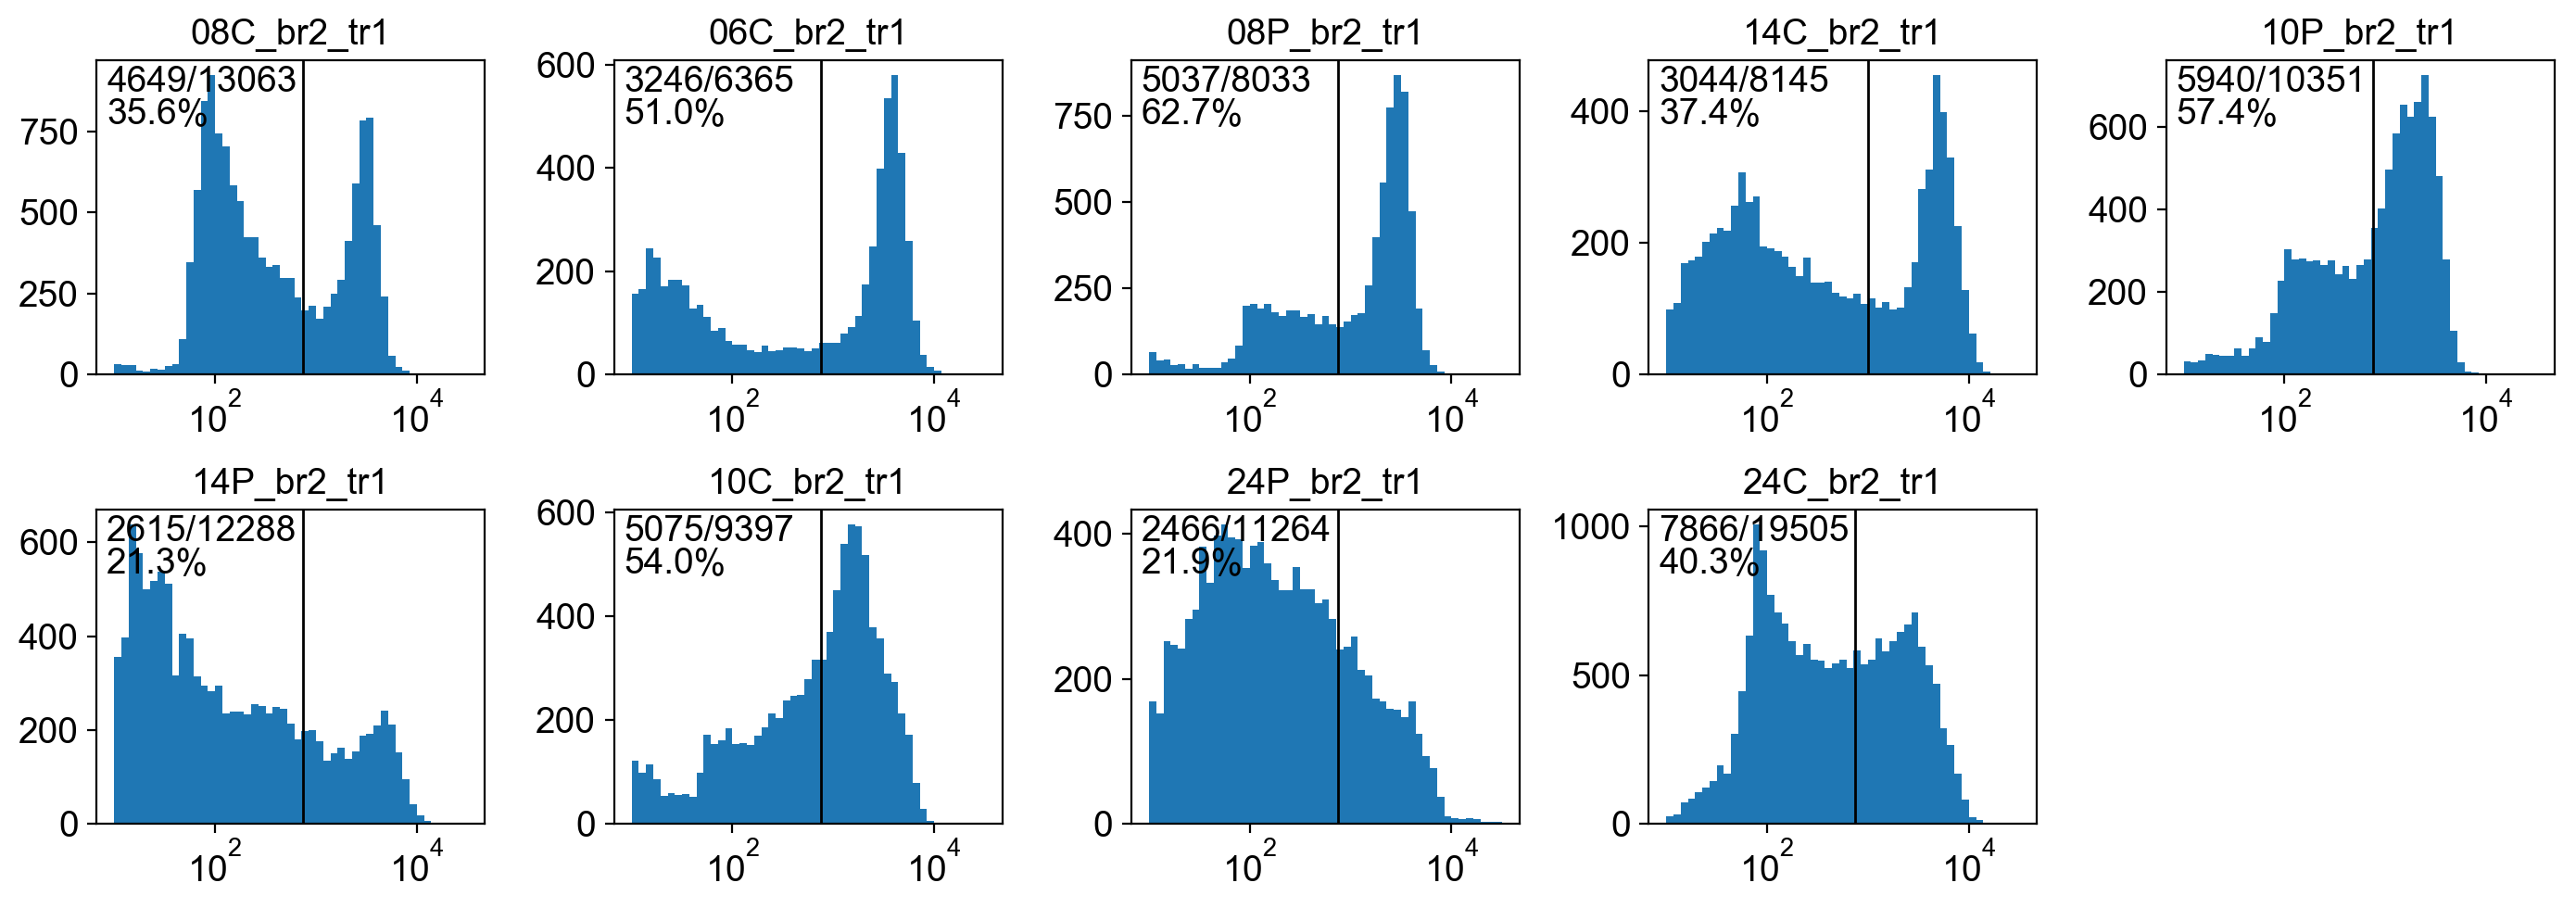

In [6]:
sample_name_br2 = []

for file in os.listdir(raw_files):
    if file.endswith('counts.tsv.gz'):
        s = file.split('.')[0]
        if 'br2' in s:
            sample_name_br2.append(s)
print (sample_name_br2)

for keys in adict_br2:
    adict_br2[keys].uns['min_tot'] = 750
    
adict_br2['14C_br2_tr1'].uns['min_tot'] = 1000

ncol = 5
nrow = int(len(adict_br2) / ncol) + 1

fig = pl.figure(figsize = (14, nrow * 2.5), dpi = 200)
for iS, s in enumerate(sample_name_br2):
    ax = pl.subplot(nrow, ncol, iS + 1)
    
    adict_br2[s].obs['n_counts'] = adict_br2[s].X.sum(1).A1
    min_tot = adict_br2[s].uns['min_tot']
    
    ax.hist(adict_br2[s].obs['n_counts'], np.logspace(1, 4.5, 50))
    ax.set_xscale('log')
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    
    ax.plot([min_tot,min_tot], yl, c='black', linewidth=1)
    ax.set_title(s)
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.grid(False)
    
    ntot = len(adict_br2[s].obs['n_counts'])
    npass = sum(adict_br2[s].obs['n_counts'] >= min_tot)
    
    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.9, '{}/{}'.format(npass, ntot), fontsize=14)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.8, '{:.1f}%'.format(npass/ntot*100), fontsize=14)
    
fig.tight_layout()


##### Replicate 3

['06C_br3_tr1', '08P_br3_tr1', '08C_br3_tr1', '14P_br3_tr1', '10C_br3_tr1', '14C_br3_tr1', '10P_br3_tr1', '24C_br3_tr1', '24P_br3_tr1']


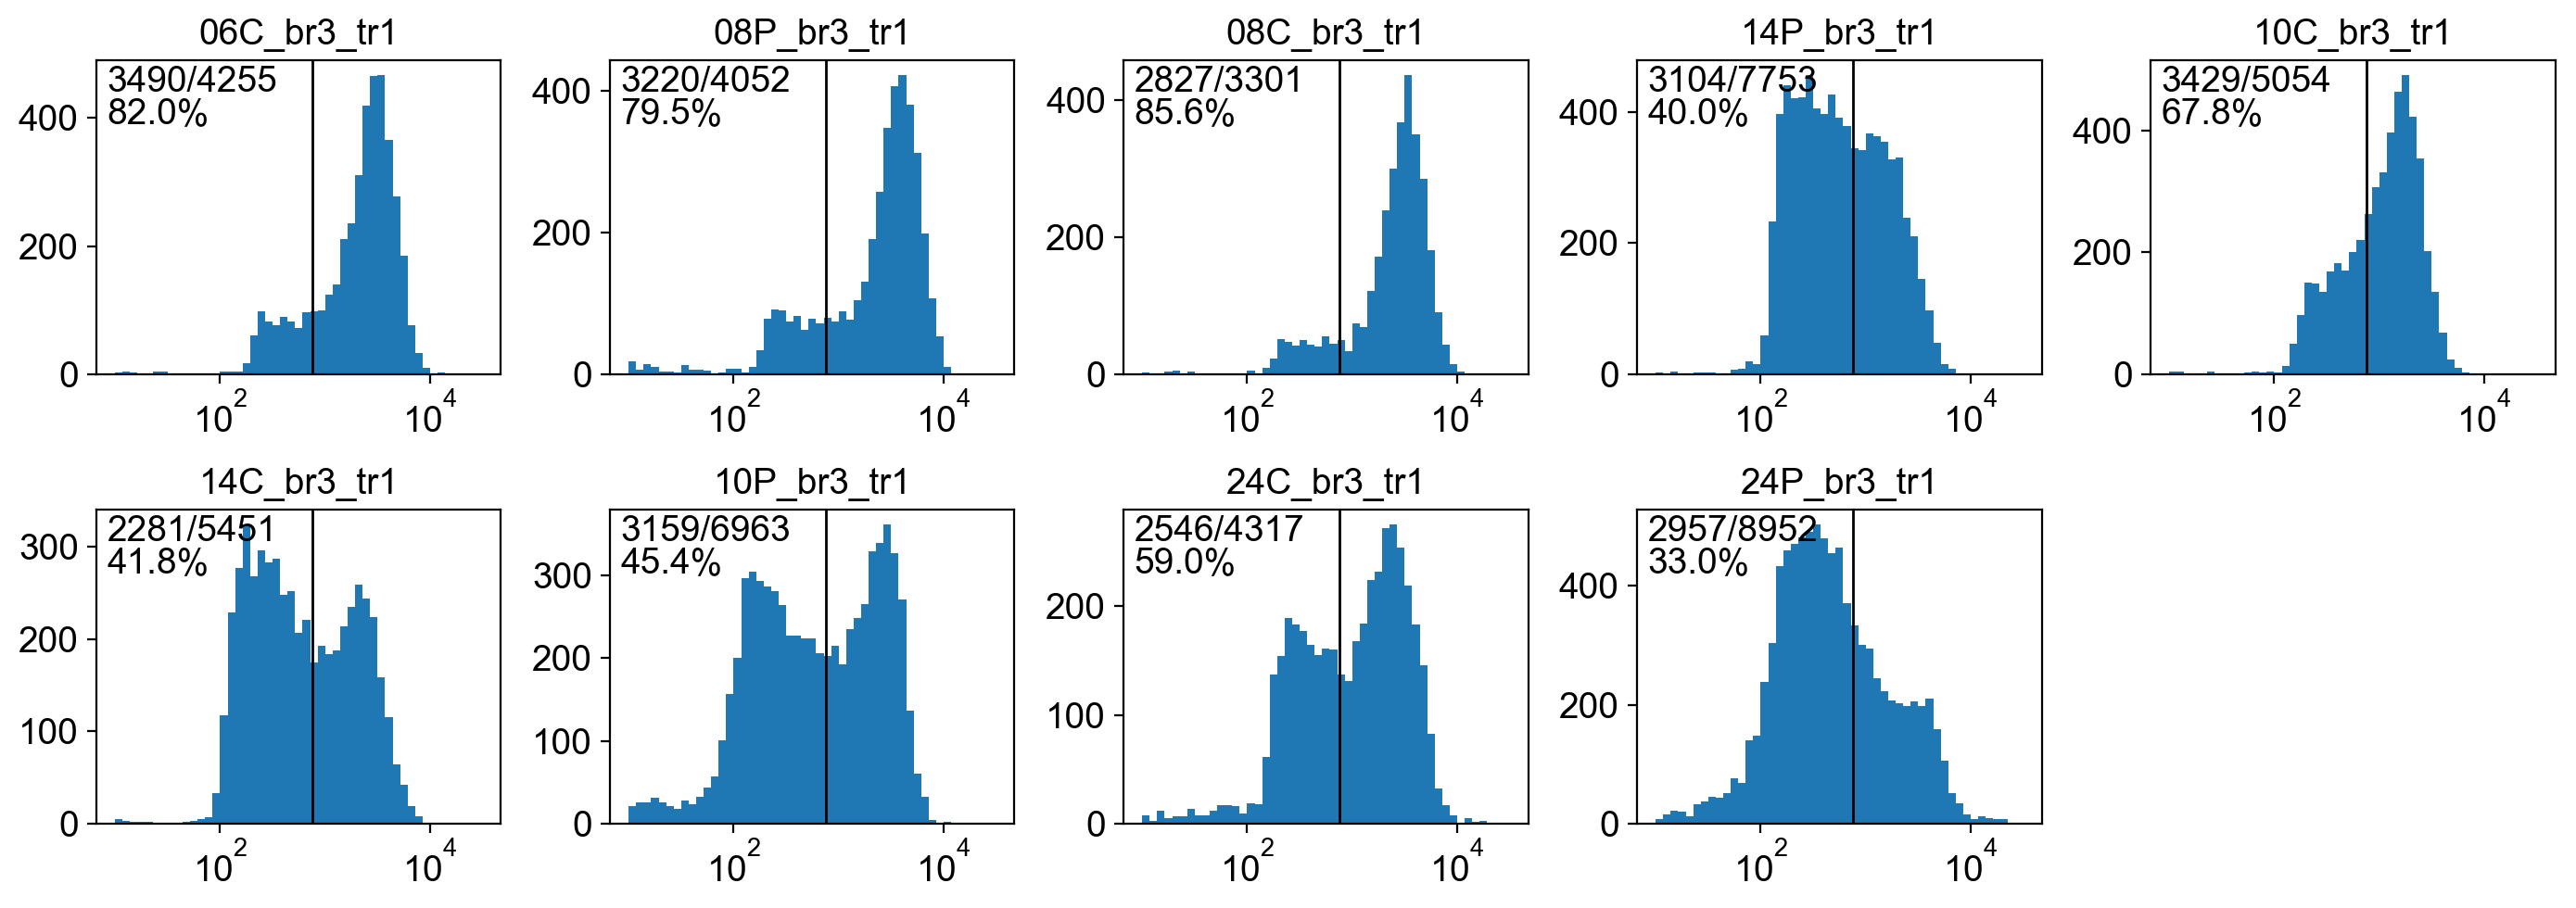

In [8]:
sample_name_br3 = []

for file in os.listdir(raw_files):
    if file.endswith('counts.tsv.gz'):
        s = file.split('.')[0]
        if 'br3' in s:
            sample_name_br3.append(s)

print (sample_name_br3)
for keys in adict_br3:
    adict_br3[keys].uns['min_tot'] = 750
    
#adict_br3['18C'].uns['min_tot'] = 1500
ncol = 5
nrow = int(len(adict_br3) / ncol) + 1

fig = pl.figure(figsize = (14, nrow * 2.5), dpi = 200)
for iS, s in enumerate(sample_name_br3):
    ax = pl.subplot(nrow, ncol, iS + 1)
    
    adict_br3[s].obs['n_counts'] = adict_br3[s].X.sum(1).A1
    min_tot = adict_br3[s].uns['min_tot']
    
    ax.hist(adict_br3[s].obs['n_counts'], np.logspace(1, 4.5, 50))
    ax.set_xscale('log')
    
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    
    ax.plot([min_tot,min_tot], yl, c='black', linewidth=1)
    ax.set_title(s)
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.grid(False)
    
    ntot = len(adict_br3[s].obs['n_counts'])
    npass = sum(adict_br3[s].obs['n_counts'] >= min_tot)
    
    
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.9, '{}/{}'.format(npass, ntot), fontsize=14)
    ax.text(xl[0] + 10**(np.log10(xl.ptp())*0.05), yl[0] + yl.ptp() * 0.8, '{:.1f}%'.format(npass/ntot*100), fontsize=14)
    
fig.tight_layout()


#### Now actually remove barcodes with too few UMIs


In [9]:
del adict['06C_br1_tr1'] # no bimodal curve and all cells have low counts so I dont trust this library

In [10]:
sample_name =  [ '08P_br1_tr1',
 '08C_br1_tr1',
 '06C_br3_tr1',
 '08C_br2_tr1',
 '08P_br3_tr1',
 '08C_br3_tr1',
 '06C_br2_tr1',
 '08P_br2_tr1',
 '14C_br2_tr1',
 '14P_br3_tr1',
 '10P_br2_tr1',
 '10C_br3_tr1',
 '14C_br3_tr1',
 '14P_br2_tr1',
 '10P_br3_tr1',
 '10C_br2_tr1',
 '24P_br2_tr1',
 '24C_br3_tr1',
 '14P_br1_tr1',
 '10C_br1_tr1',
 '24P_br3_tr1',
 '24C_br2_tr1',
 '14C_br1_tr1',
 '10P_br1_tr1']

In [11]:
for iS, s in enumerate(sample_name):
    n_orig = adict[s].shape[0]
    adict[s] = adict[s][adict[s].obs['n_counts'] >= adict[s].uns['min_tot']]
    n_pass = adict[s].shape[0]
    print(s, n_orig, n_pass)

08P_br1_tr1 5494 3678
08C_br1_tr1 5171 2589
06C_br3_tr1 4255 3490
08C_br2_tr1 13063 4649
08P_br3_tr1 4052 3220
08C_br3_tr1 3301 2827
06C_br2_tr1 6365 3578
08P_br2_tr1 8033 5037
14C_br2_tr1 8145 3044
14P_br3_tr1 7753 3104
10P_br2_tr1 10351 5940
10C_br3_tr1 5054 3429
14C_br3_tr1 5451 2281
14P_br2_tr1 12288 2615
10P_br3_tr1 6963 3159
10C_br2_tr1 9397 5075
24P_br2_tr1 11264 2466
24C_br3_tr1 4317 2546
14P_br1_tr1 13295 2727
10C_br1_tr1 7461 2845
24P_br3_tr1 8952 2957
24C_br2_tr1 19505 7866
14C_br1_tr1 7227 2741
10P_br1_tr1 23033 2933


### Store a backup of the filtered data

In [12]:
adict_backup = {}
for iS, s in enumerate(sample_name):
    adict_backup[s] = adict[s].copy()

### Merge data to a single adata:

In [ ]:
adata = sc.AnnData.concatenate(*[adict_backup[s] for s in sample_name], 
                               batch_categories=sample_name,
                               batch_key='sample')

print(adata)

AnnData object with n_obs × n_vars = 84796 × 30677 
    obs: 'n_counts', 'replicate', 'sample', 'time_point', 'treatment', 'trep'


In [ ]:

### Make adata_time:

adata_time = sc.AnnData.concatenate(*[adict[s] for s in sample_name], 
                               batch_categories=sample_name,
                               batch_key='sample')

print(adata_time)

for obs_name in ['sample','treatment', 'time_point']:
    adata_time.obs[obs_name] = pd.Categorical(adata_time.obs[obs_name])

adata_time.obs.head()

AnnData object with n_obs × n_vars = 84796 × 30677 
    obs: 'n_counts', 'replicate', 'sample', 'time_point', 'treatment', 'trep'


n_counts replicate       sample time_point  treatment trep
0-08P_br1_tr1    8992.0         1  08P_br1_tr1         08  perturbed    1
1-08P_br1_tr1    4385.0         1  08P_br1_tr1         08  perturbed    1
2-08P_br1_tr1    3772.0         1  08P_br1_tr1         08  perturbed    1
3-08P_br1_tr1    4117.0         1  08P_br1_tr1         08  perturbed    1
4-08P_br1_tr1    3167.0         1  08P_br1_tr1         08  perturbed    1

In [ ]:
set(adata.obs['time_point'])

{'06', '08', '10', '14', '24'}

In [ ]:
adata_8 = adata[adata.obs['time_point'] == '08']
adata_10 = adata[adata.obs['time_point'] == '10']
adata_14 = adata[adata.obs['time_point'] == '14']
adata_24 = adata[adata.obs['time_point'] == '24']


In [ ]:
for obs_name in ['sample','treatment', 'time_point', 'replicate', 'trep']:
    adata_8.obs[obs_name] = pd.Categorical(adata_8.obs[obs_name])

In [ ]:
for obs_name in ['sample','treatment', 'time_point', 'replicate', 'trep']:
    adata_10.obs[obs_name] = pd.Categorical(adata_10.obs[obs_name])

In [ ]:
for obs_name in ['sample','treatment', 'time_point', 'replicate', 'trep']:
    adata_14.obs[obs_name] = pd.Categorical(adata_14.obs[obs_name])

In [ ]:
for obs_name in ['sample','treatment', 'time_point', 'replicate', 'trep']:
    adata_24.obs[obs_name] = pd.Categorical(adata_24.obs[obs_name])

- #### Total count normalization
- #### Store unfiltered data as `adata.raw` - used in later steps
- #### Remove lowly expressed genes

In [ ]:

sc.pp.normalize_per_cell(adata_8, counts_per_cell_after=adata_8.obs['n_counts'].mean())
adata_8.raw = adata_8
sc.pp.filter_genes(adata_8, min_cells=3)


filtered out 2450 genes that are detected in less than 3 cells


In [ ]:

sc.pp.normalize_per_cell(adata_10, counts_per_cell_after=adata_10.obs['n_counts'].mean())
adata_10.raw = adata_10
sc.pp.filter_genes(adata_10, min_cells=3)


filtered out 1834 genes that are detected in less than 3 cells


In [ ]:

sc.pp.normalize_per_cell(adata_14, counts_per_cell_after=adata_14.obs['n_counts'].mean())
adata_14.raw = adata_14
sc.pp.filter_genes(adata_14, min_cells=3)


filtered out 2118 genes that are detected in less than 3 cells


In [ ]:

sc.pp.normalize_per_cell(adata_24, counts_per_cell_after=adata_24.obs['n_counts'].mean())
adata_24.raw = adata_24
sc.pp.filter_genes(adata_24, min_cells=3)


filtered out 3797 genes that are detected in less than 3 cells


#### Identify highly variable genes


1537 genes passing filter


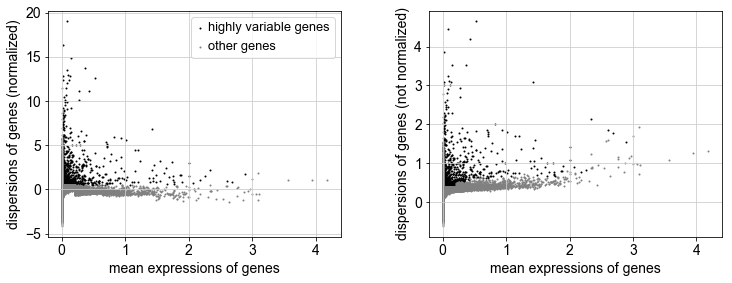

In [ ]:

filter_result_8 = sc.pp.filter_genes_dispersion(adata_8.X, min_mean=0.01, max_mean=3, min_disp=0.5)

print('{} genes passing filter'.format(filter_result_8['gene_subset'].sum()))

sc.pl.filter_genes_dispersion(filter_result_8)

adata_8 = adata_8[:,np.array(pd.DataFrame(filter_result_8)['gene_subset'])] # adata_8 with only variable genes


4997 genes passing filter


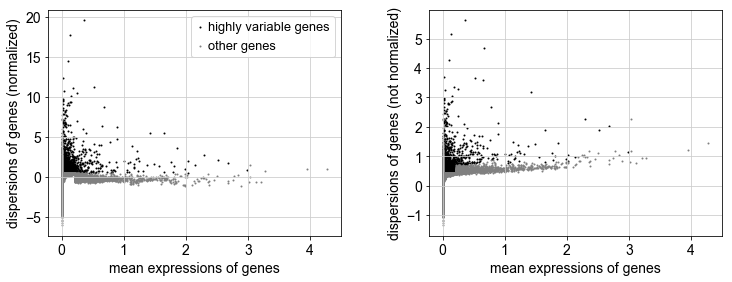

In [ ]:

filter_result10 = sc.pp.filter_genes_dispersion(adata_10.X, min_mean=0.01, max_mean=3, min_disp=0.5)

print('{} genes passing filter'.format(filter_result10['gene_subset'].sum()))

sc.pl.filter_genes_dispersion(filter_result10)

adata_10 = adata_10[:,np.array(pd.DataFrame(filter_result10)['gene_subset'])] # adata_10 with only variable genes



3977 genes passing filter


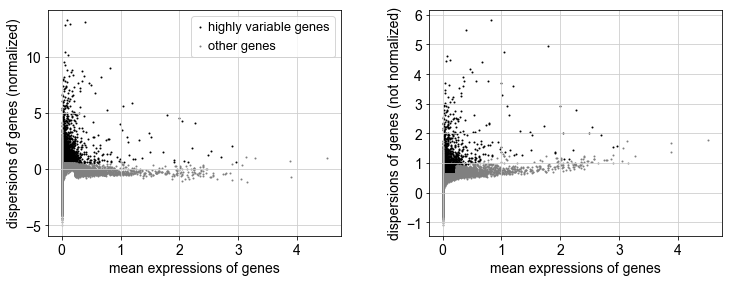

In [ ]:

filter_result14 = sc.pp.filter_genes_dispersion(adata_14.X, min_mean=0.01, max_mean=3, min_disp=0.5)

print('{} genes passing filter'.format(filter_result14['gene_subset'].sum()))

sc.pl.filter_genes_dispersion(filter_result14)

adata_14 = adata_14[:,np.array(pd.DataFrame(filter_result14)['gene_subset'])] # adata_14 with only variable genes



1958 genes passing filter


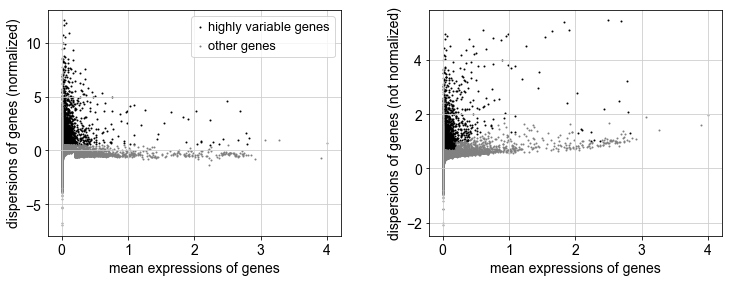

In [ ]:

filter_result24 = sc.pp.filter_genes_dispersion(adata_24.X, min_mean=0.01, max_mean=3, min_disp=0.5)

print('{} genes passing filter'.format(filter_result24['gene_subset'].sum()))

sc.pl.filter_genes_dispersion(filter_result24)

adata_24 = adata_24[:,np.array(pd.DataFrame(filter_result24)['gene_subset'])] # adata_24 with only variable genes



In [ ]:
cc_genes_dan = ['cdk1','mcm2','mcm7','rrm2','cenpa', 'cdc6', 'ccnf', 'cdca4','ccnd1', 'kif4']
house_keeping = ['hmgb1b', 'hmgb3a', 'hspd1', 'hspa9', 'rplp0', 'hnrnpaba', 'rps2',
                  'rps12', 'rpl12', 'rps13', 'rps14', 'rps15a','rpl10', 'rps3a', 
                  'rpl31', 'rpl37', 'rps6', 'rpl9', 'rpl11', 'rpl34', 'rpl13', 
                  'rpl36a', 'rpl26', 'rps8a', 'rpl21','rps27.1','rpl27a', 'cirbpb']


In [ ]:
# cell cycle genes:


cc_iter1  = hf.corr_coeff(adata_8 , cc_genes_dan, 0.3)[1]
print ('first iteration done')
cc_iter2  = hf.corr_coeff(adata_8 , cc_iter1, 0.3)[1]
print ('second iteration done')

cc_to_remove  = list(set(list(cc_iter1) + list(cc_iter2)))

first iteration done
second iteration done


In [ ]:

hk_iter1  = hf.corr_coeff(adata_8 , house_keeping, 0.3)[1]
hk_iter2  = hf.corr_coeff(adata_8 , hk_iter1 , 0.3)[1]

hk_to_remove  = list(set(list(hk_iter1) + list(hk_iter2)))

to_remove  = np.array(cc_to_remove + hk_to_remove )

gene_removal  =np.in1d(adata_8.var_names,to_remove ) # remove ribo, mito or cell cycle genes

adata_8  = adata_8[:,(1-gene_removal).astype(bool)] # update adata_8 





In [ ]:
# cell cycle genes:


cc_iter1  = hf.corr_coeff(adata_10 , cc_genes_dan, 0.3)[1]
print ('first iteration done')
cc_iter2  = hf.corr_coeff(adata_10 , cc_iter1, 0.3)[1]
print ('second iteration done')

cc_to_remove  = list(set(list(cc_iter1) + list(cc_iter2)))


hk_iter1  = hf.corr_coeff(adata_10 , house_keeping, 0.3)[1]
hk_iter2  = hf.corr_coeff(adata_10 , hk_iter1 , 0.3)[1]

hk_to_remove  = list(set(list(hk_iter1) + list(hk_iter2)))

to_remove  = np.array(cc_to_remove + hk_to_remove )

gene_removal  =np.in1d(adata_10.var_names,to_remove ) # remove ribo, mito or cell cycle genes

adata_10  = adata_10[:,(1-gene_removal).astype(bool)] # update adata_10 





first iteration done
second iteration done


KeyboardInterrupt: 

In [ ]:
# cell cycle genes:

cc_iter1  = hf.corr_coeff(adata_14 , cc_genes_dan, 0.3)[1]
print ('first iteration done')
cc_iter2  = hf.corr_coeff(adata_14 , cc_iter1, 0.3)[1]
print ('second iteration done')

cc_to_remove  = list(set(list(cc_iter1) + list(cc_iter2)))

house_keeping = ['hmgb1b', 'hmgb3a', 'hspd1', 'hspa9', 'rplp0', 'hnrnpaba', 'rps2', 'rps12', 'rpl12', 'rps13', 'rps14', 'rps15a', 'rpl10', 'rps3a', 'rpl31', 'rpl37', 'rps6', 'rpl9', 'rpl11', 'rpl34', 'rpl13', 'rpl36a', 'rpl26', 'rps8a', 'rpl21', 'rps27.1', 'rpl27a', 'cirbpb'] 

hk_iter1  = hf.corr_coeff(adata_14 , house_keeping, 0.3)[1]
print ('first iteration done')
hk_iter2  = hf.corr_coeff(adata_14 , hk_iter1 , 0.3)[1]
print ('second iteration done')

hk_to_remove  = list(set(list(hk_iter1) + list(hk_iter2)))

to_remove  = np.array(cc_to_remove + hk_to_remove )

gene_removal  =np.in1d(adata_14.var_names,to_remove ) # remove ribo, mito or cell cycle genes

adata_14  = adata_14[:,(1-gene_removal).astype(bool)] # update adata_14 





In [ ]:
# cell cycle genes:

cc_iter1  = hf.corr_coeff(adata_24 , cc_genes_dan, 0.3)[1]
print ('first iteration done')
cc_iter2  = hf.corr_coeff(adata_24 , cc_iter1, 0.3)[1]
print ('second iteration done')

cc_to_remove  = list(set(list(cc_iter1) + list(cc_iter2)))


hk_iter1  = hf.corr_coeff(adata_24 , house_keeping, 0.3)[1]
print ('first iteration done')
hk_iter2  = hf.corr_coeff(adata_24 , hk_iter1 , 0.3)[1]
print ('second iteration done')

hk_to_remove  = list(set(list(hk_iter1) + list(hk_iter2)))

to_remove  = np.array(cc_to_remove + hk_to_remove )

gene_removal  =np.in1d(adata_24.var_names,to_remove ) # remove ribo, mito or cell cycle genes

adata_24  = adata_24[:,(1-gene_removal).astype(bool)] # update adata_24 





- #### Scale data (z-score)
- #### Run PCA
- #### Get nearest neighbors
- #### Get umap embedding
- #### Get louvian clusters




In [ ]:

sc.pp.scale(adata_8)
sc.tl.pca(adata_8, n_comps=50)

import bbknn
bbknn.bbknn(adata_8,batch_key='replicate')
#sc.pp.bbknn(adata_8, batch_key='replicate', n_neighbors=5, use_rep='X_pca',save_knn=True)
#sc.pp.neighbors(adata_8, n_neighbors=5, use_rep='X_pca')
sc.tl.umap(adata_8)
sc.tl.louvain(adata_8)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.60)
computing batch balanced neighbors
	finished (0:00:03.53)
computing UMAP
    using 'X_pca' with n_pcs = 50
    finished (0:00:10.79)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:03.80)


In [ ]:

sc.pp.scale(adata_10)
sc.tl.pca(adata_10, n_comps=50)
#bbknn.bbknn(adata_10,batch_key='replicate')
sc.pp.neighbors(adata_10, n_neighbors=5, use_rep='X_pca')
sc.tl.umap(adata_10)
sc.tl.louvain(adata_10)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:01.45)
computing neighbors
    finished (0:00:03.23)
computing UMAP


/Users/kalki/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


    finished (0:00:09.20)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.29)


In [ ]:

sc.pp.scale(adata_14)
sc.tl.pca(adata_14, n_comps=50)
#bbknn.bbknn(adata_14,batch_key='replicate')
sc.pp.neighbors(adata_14, n_neighbors=5, use_rep='X_pca')
sc.tl.umap(adata_14)
sc.tl.louvain(adata_14)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:01.06)
computing neighbors
    finished (0:00:02.93)
computing UMAP
    finished (0:00:06.59)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.58)


In [ ]:

sc.pp.scale(adata_24)
sc.tl.pca(adata_24, n_comps=50)
#bbknn.bbknn(adata_24,batch_key='replicate')
sc.pp.neighbors(adata_24, n_neighbors=5, use_rep='X_pca')
sc.tl.umap(adata_24)
sc.tl.louvain(adata_24)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00.42)
computing neighbors
    finished (0:00:02.95)
computing UMAP


/Users/kalki/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components


    finished (0:00:06.43)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.20)


#### Plotting:

- umap graph with louvian cluster annotations
- force directed layout with louvian cluster annotations
- force directed layout with genotype

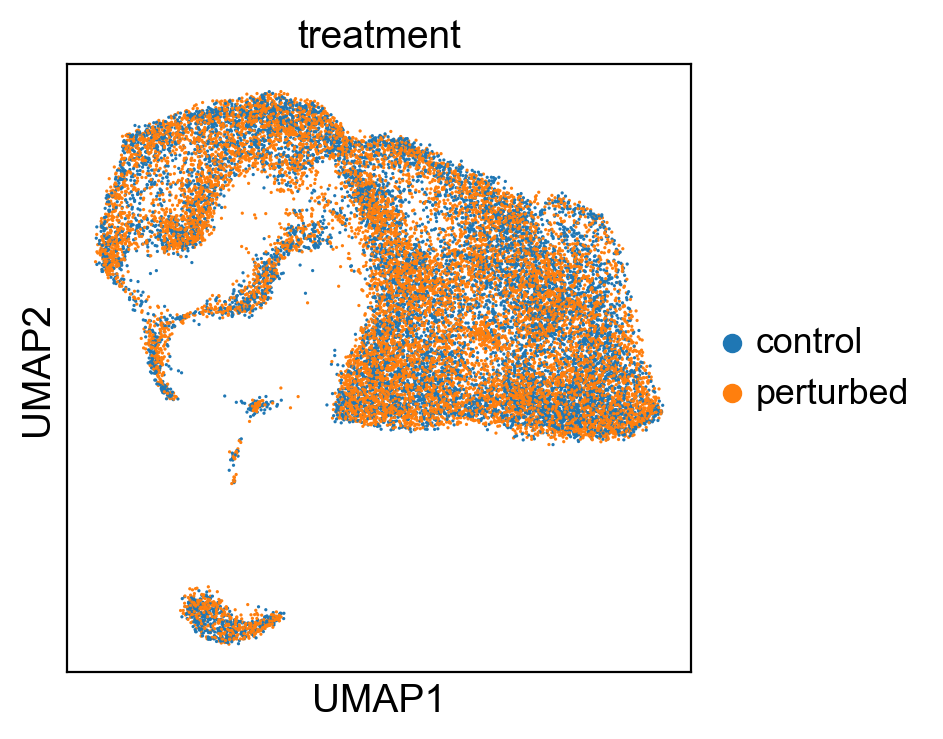

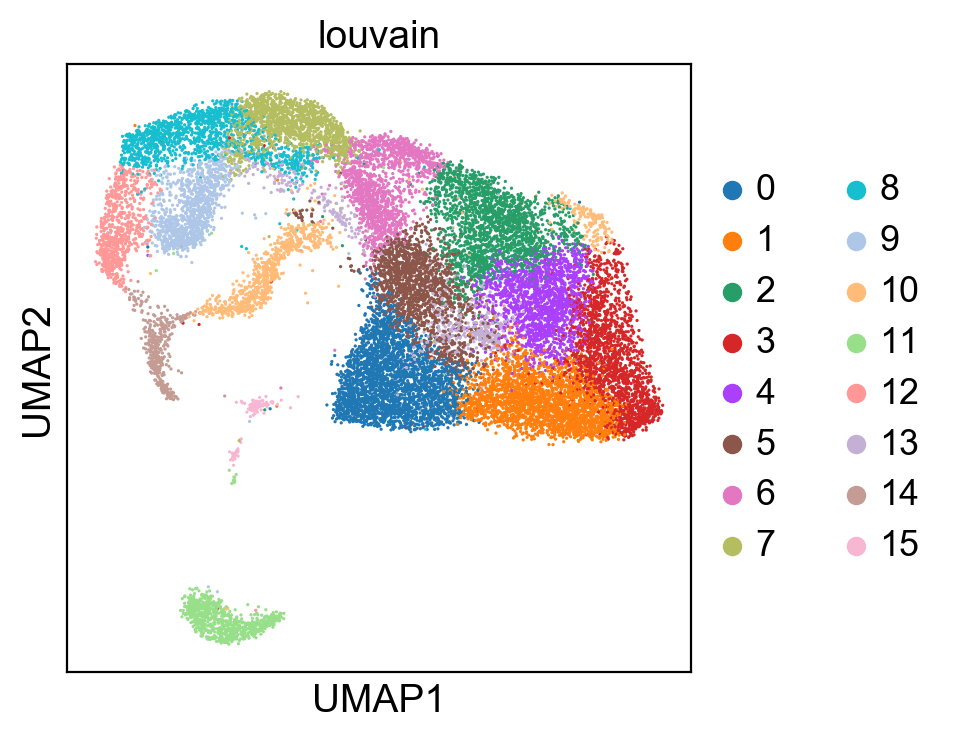

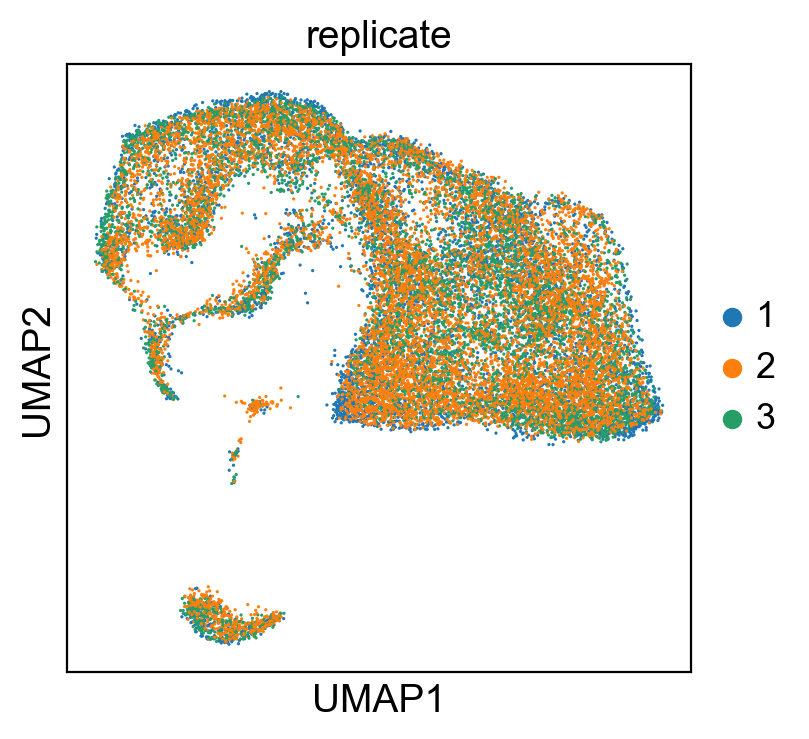

In [ ]:

sc.settings.set_figure_params(dpi=100)  # low dpi (dots per inch) yields small inline figures
''' 

pl.rcParams['font.family'] = 'century-gothic'
#pl.rcParams['font.sans-serif'] = ['Tahoma']

pl.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "black",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})
    
'''

sc.pl.umap(adata_8, color = 'treatment')
sc.pl.umap(adata_8, color = 'louvain')
sc.pl.umap(adata_8, color = 'replicate')

#sc.pl.draw_graph(adata_8, 'fa', 'louvain')


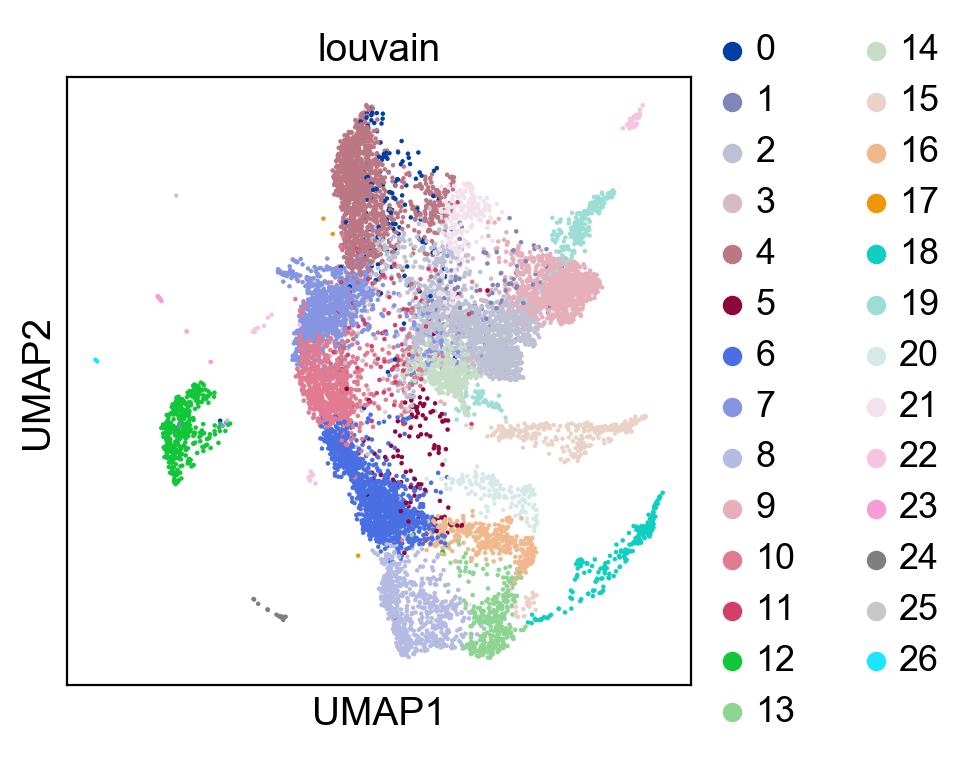

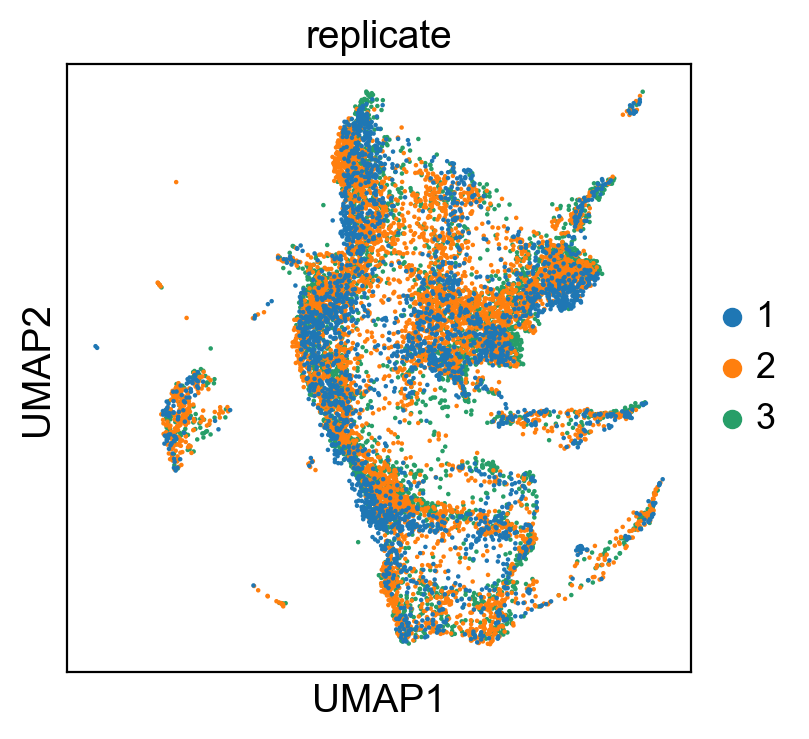

In [ ]:

sc.pl.umap(adata_10[adata_10.obs.treatment == 'control'], color = 'louvain')
sc.pl.umap(adata_10[adata_10.obs.treatment == 'control'], color = 'replicate')

#sc.pl.draw_graph(adata_18, 'fa', 'louvain')


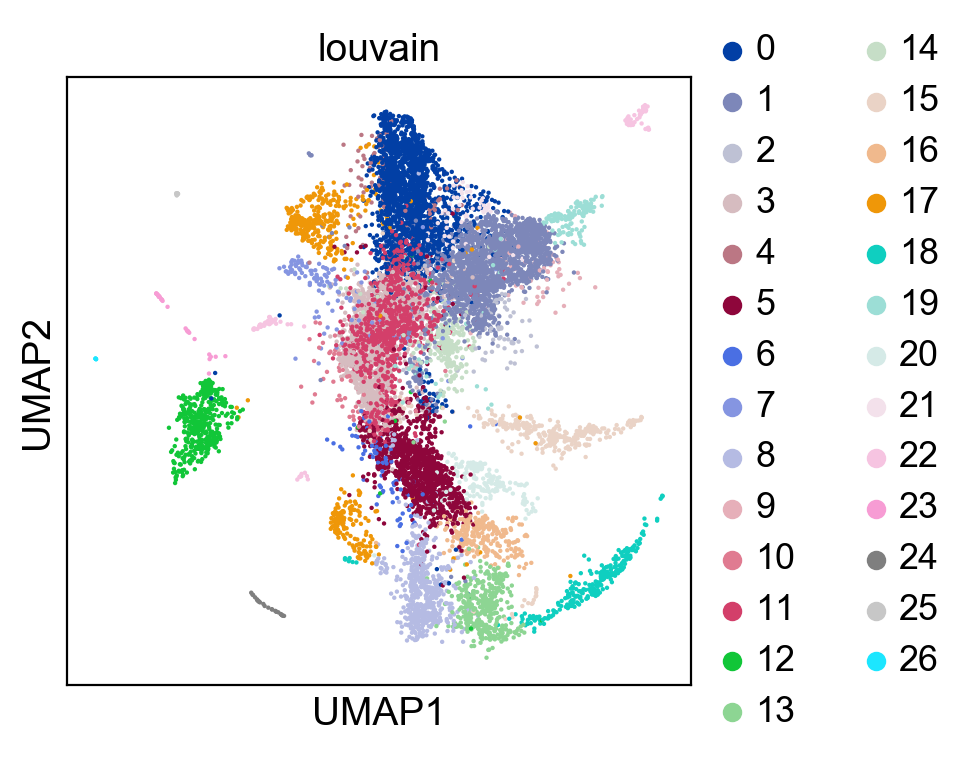

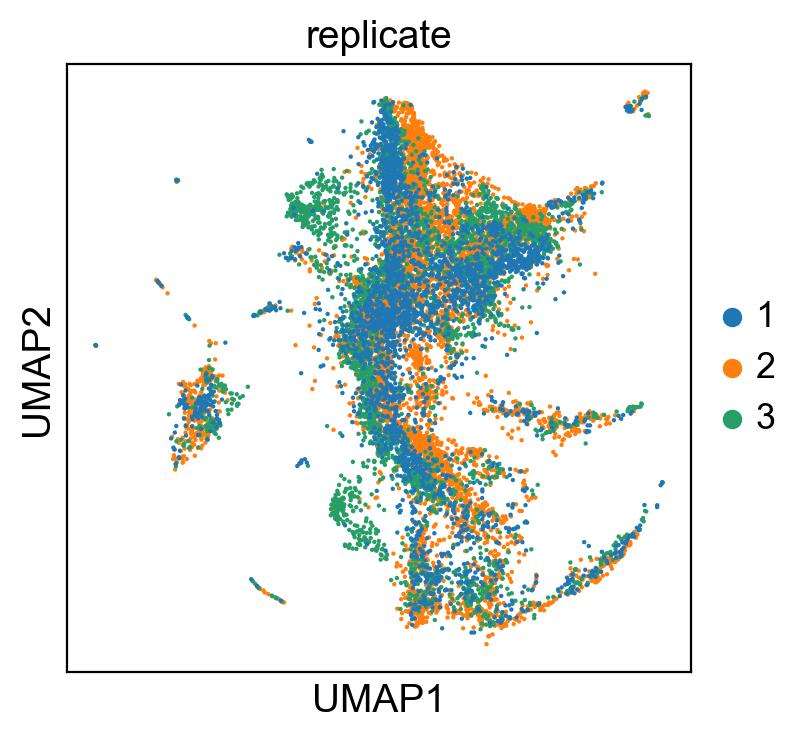

In [ ]:

sc.pl.umap(adata_10[adata_10.obs.treatment == 'hua'], color = 'louvain')
sc.pl.umap(adata_10[adata_10.obs.treatment == 'hua'], color = 'replicate')

#sc.pl.draw_graph(adata_18, 'fa', 'louvain')


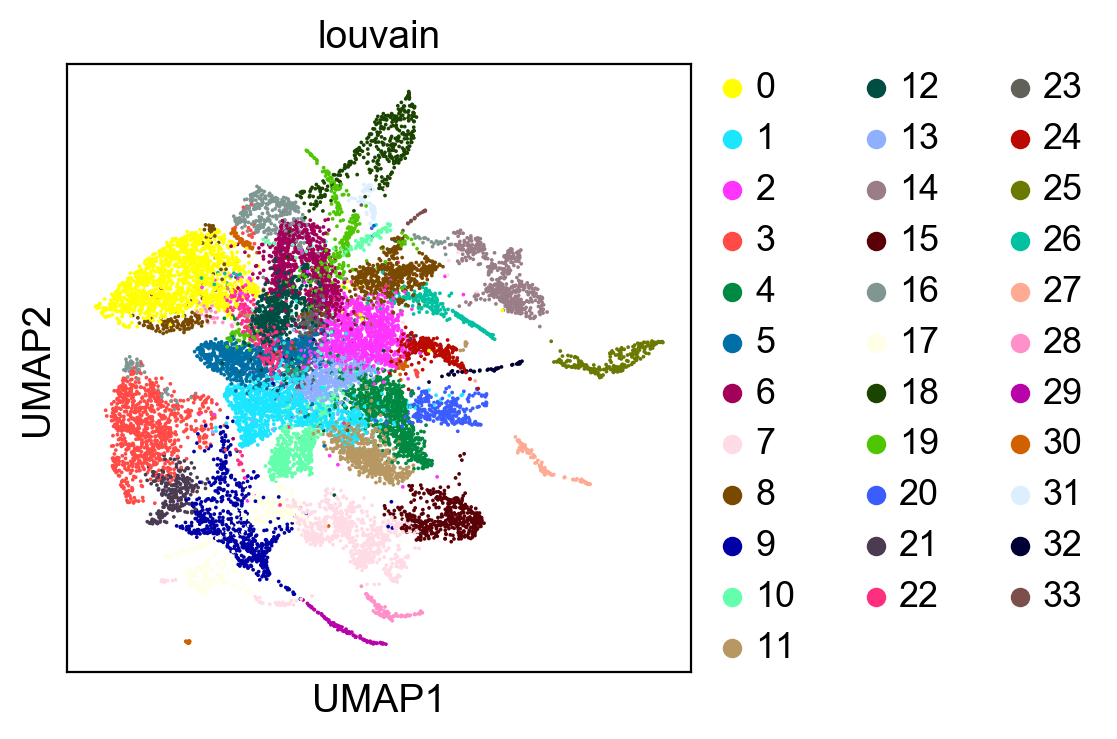

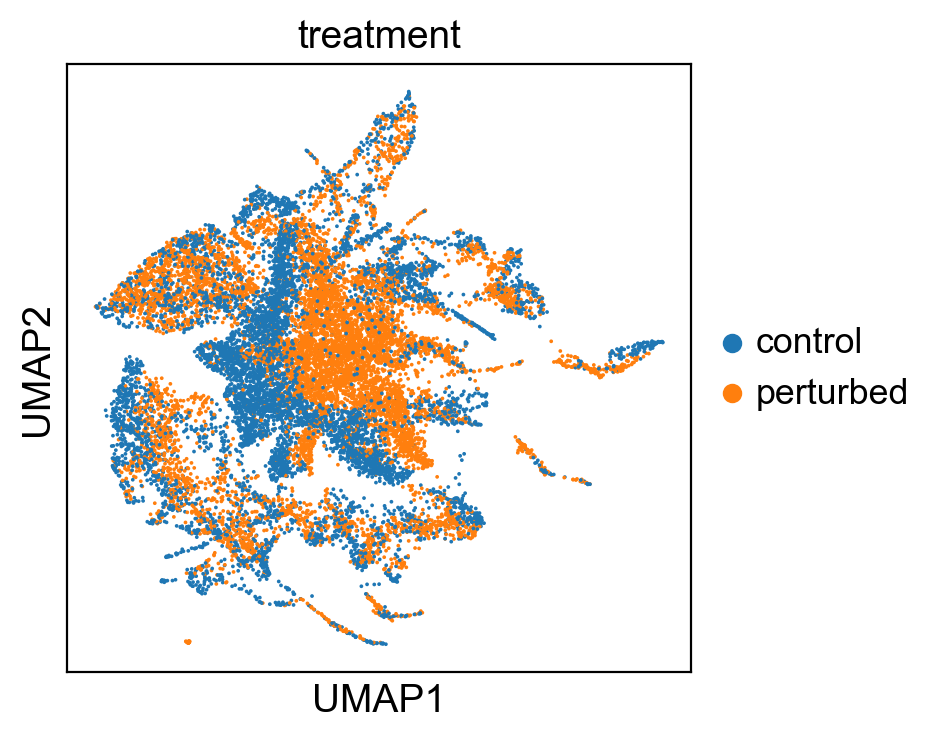

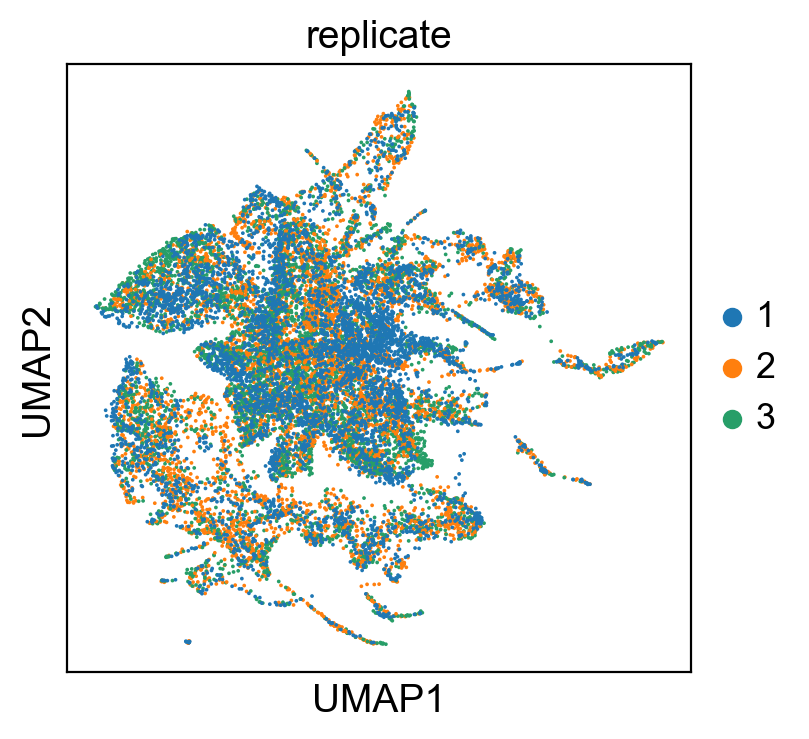

In [ ]:


sc.pl.umap(adata_14, color = 'louvain')
sc.pl.umap(adata_14, color = 'treatment')
sc.pl.umap(adata_14, color = 'replicate')


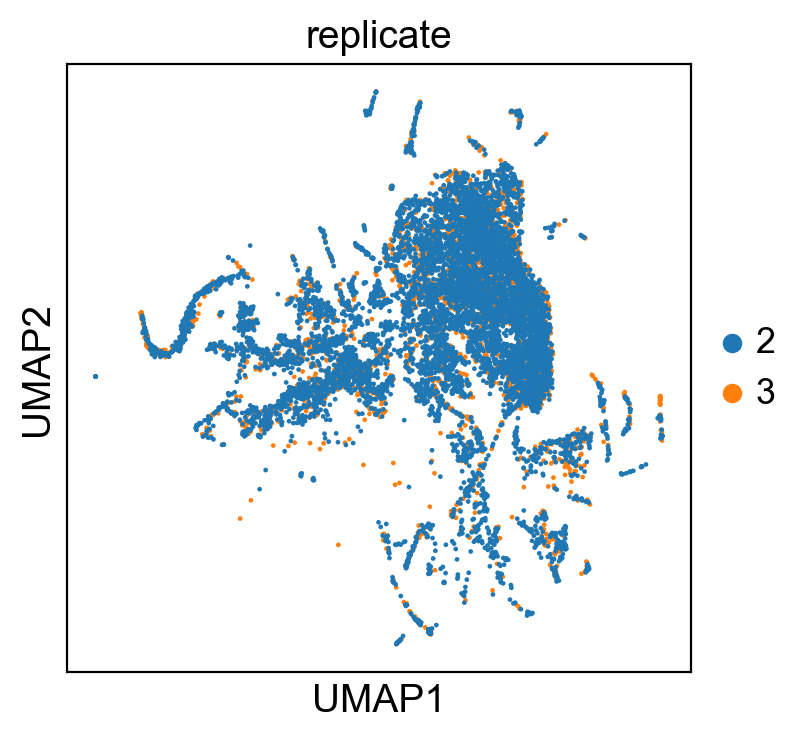

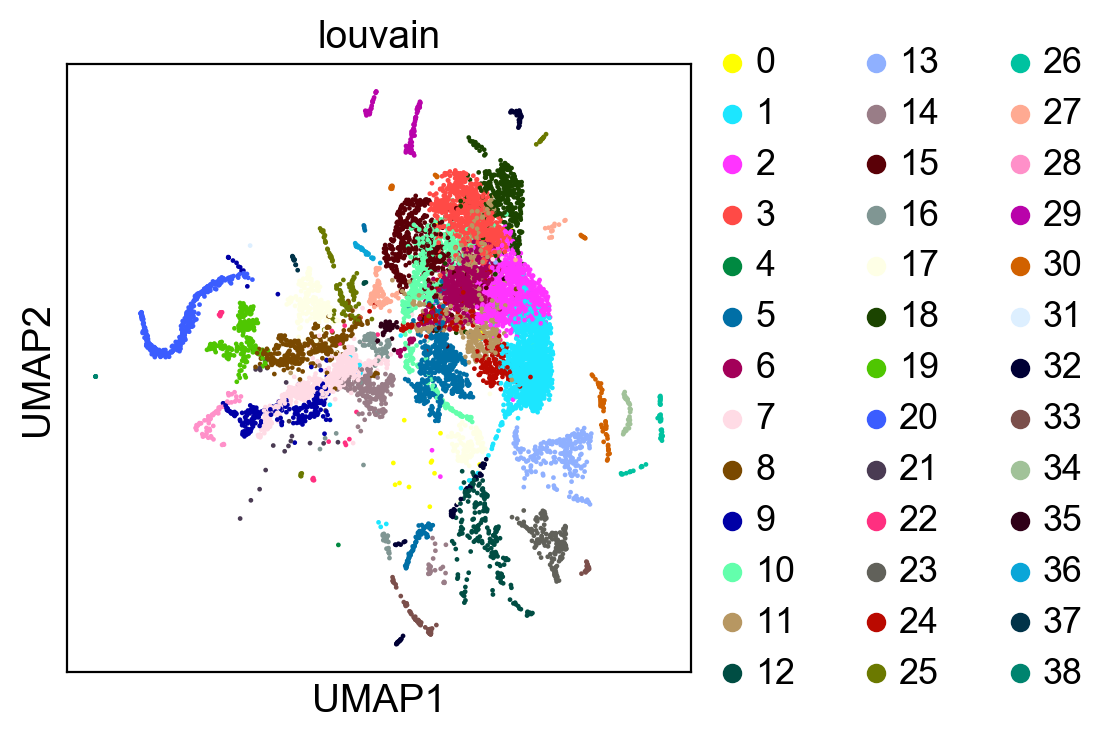

In [ ]:
sc.pl.umap(adata_24[adata_24.obs.treatment == 'control'], color = 'replicate')
sc.pl.umap(adata_24[adata_24.obs.treatment == 'control'], color = 'louvain')


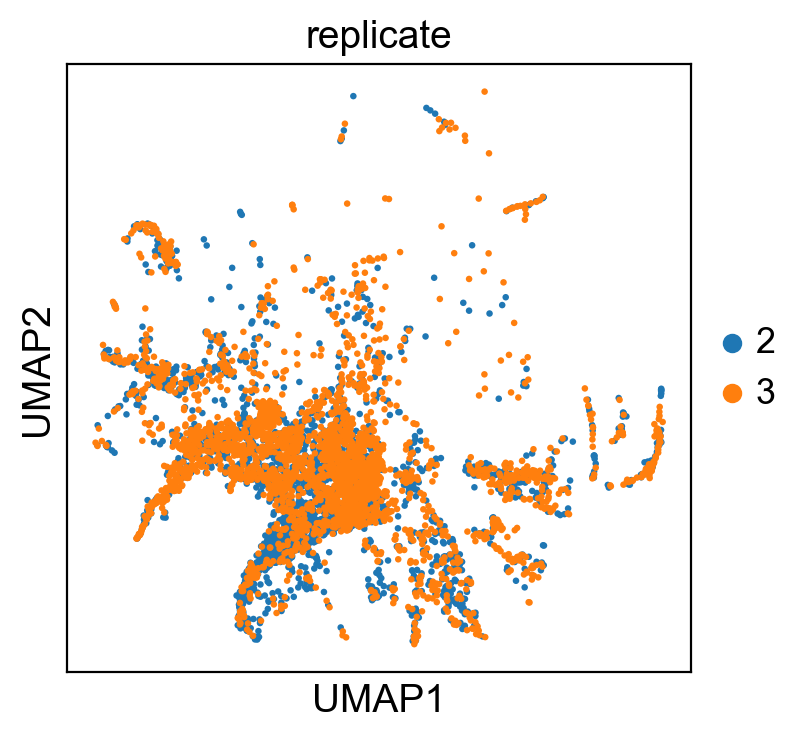

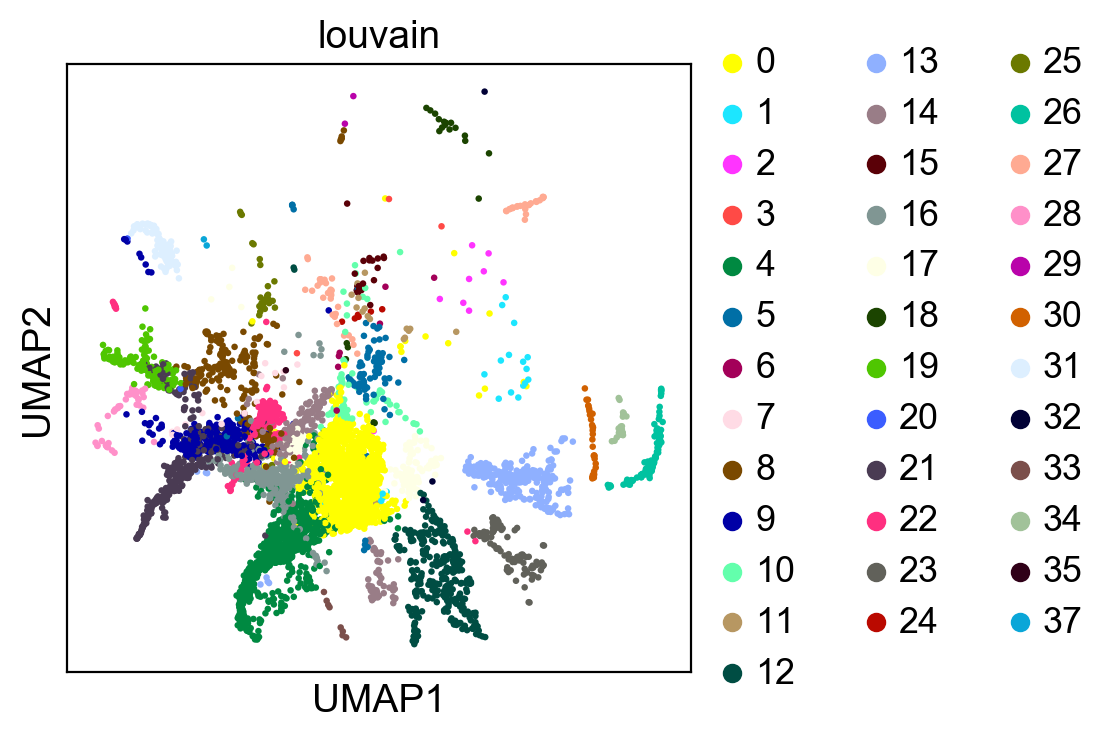

In [ ]:
sc.pl.umap(adata_24[adata_24.obs.treatment == 'hua'], color = 'replicate')
sc.pl.umap(adata_24[adata_24.obs.treatment == 'hua'], color = 'louvain')


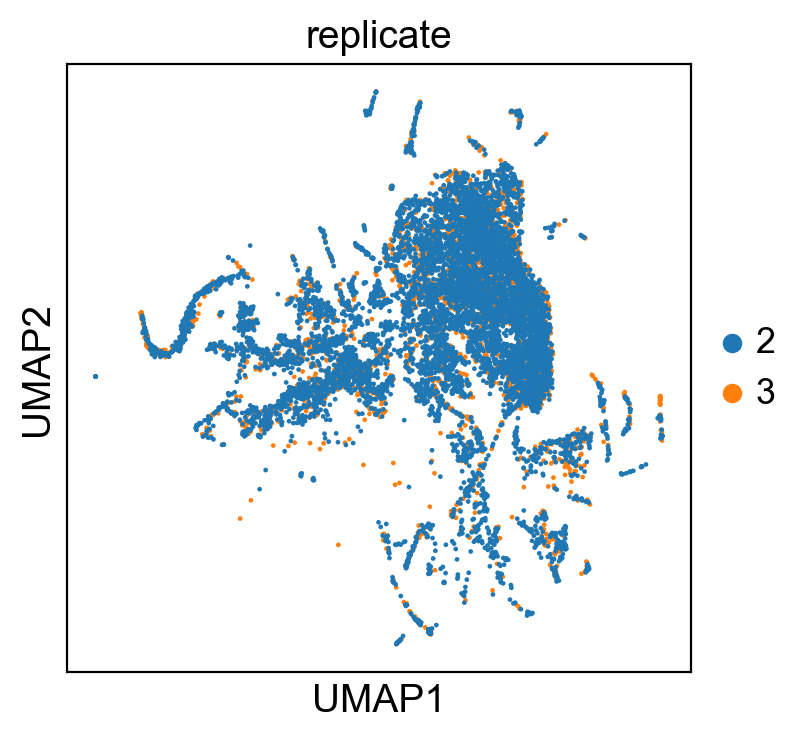

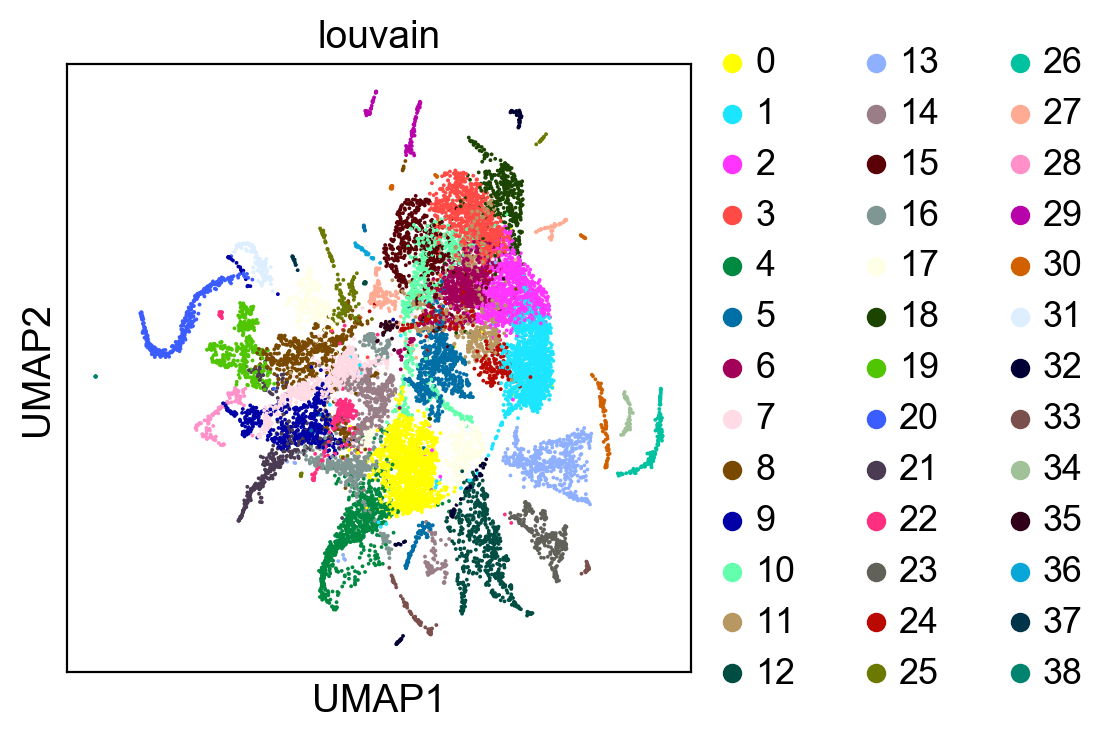

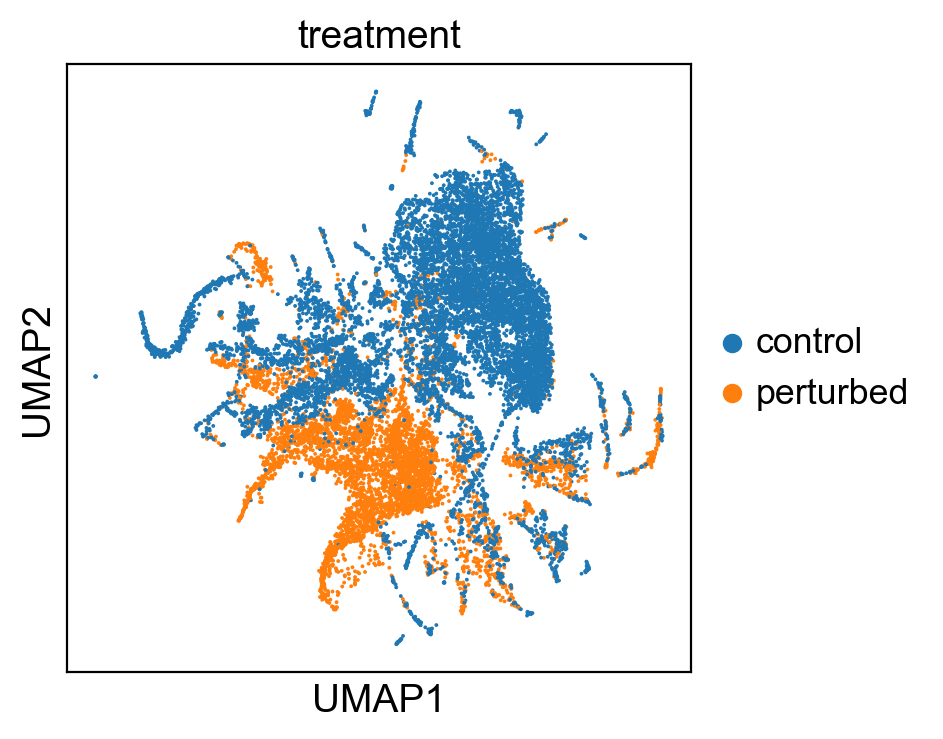

In [ ]:
sc.pl.umap(adata_24[adata_24.obs.treatment == 'control'], color = 'replicate')

sc.pl.umap(adata_24, color = 'louvain')
sc.pl.umap(adata_24, color = 'treatment')
